In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_gpu = torch.cuda.is_available()
print(device)

cuda:0


# Initialize for CPU & GPU

In [2]:
if use_gpu:
    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --no-index --find-links=file:///kaggle/input/torch-geometric
#     !pip install torch_geometric_temporal  
else:
#     !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git
#     !pip install torch_geometric_temporal


Looking in links: file:///kaggle/input/torch-geometric
Processing /kaggle/input/torch-geometric/torch_scatter-2.1.1-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_sparse-0.6.17-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_cluster-1.6.1-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_spline_conv-1.2.2-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_geometric-2.3.1-py3-none-any.whl


# Import

In [3]:
import numpy as np
import pandas as pd
import os
import re
import json
from scipy.special import perm
from itertools import combinations,chain
from typing import List, Union
from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder
import networkx as nx

import matplotlib.pyplot as plt
import pickle
import time
from torch import nn
from torch.nn import Linear as Lin
from torch.nn import ReLU, LeakyReLU
from torch.nn import Sequential as Seq
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv
from torch import autograd
from torch_geometric.nn.models import InnerProductDecoder
from torch_geometric.utils import to_dense_adj

from sklearn.model_selection import train_test_split

# DataLoader

In [4]:
Edge_Flag = List[Union[np.ndarray, None]]
Edge_Index = List[Union[np.ndarray, None]]
Edge_Attr = List[Union[np.ndarray, None]]

Node_Flag = List[Union[np.ndarray, None]]
Node_Index = List[Union[np.ndarray, None]]
Node_Attr = List[Union[np.ndarray, None]]
Additional_Attr = List[np.ndarray]



class GraphSignal(object):
    # dynamic node static node attr dynamic edge and edge attr
    def __init__(
        self,
        edge_flag: Edge_Flag,
        edge_index: Edge_Index,
        edge_attr: Edge_Attr,
        node_flag: Node_Flag,
        node_index: Node_Index,
        node_attr: Node_Attr,
        ts_list: List,
        path: str,
    ):
        
        self.raw_edge_flag = torch.LongTensor(edge_flag[:-1])
        self.raw_edge_index = torch.LongTensor(edge_index).T
        self.raw_edge_attr = edge_attr
        self.raw_node_attr = node_attr 
        self.node_flag = torch.LongTensor(node_flag[:-1])
        self.node_index = torch.LongTensor(node_index)
        
        self.ts_list = ts_list
        
        self.path = path
        
        self.node_attr = None
        self.edge_flag = None
        self.edge_index = None
        
        self._set_snapshot_count()
        self._set_node_count()

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.ts_list)
    
    def _set_node_count(self):
        self.node_count = self.raw_node_attr.shape[0]
    
    def encode_edge_attr(self, enocder):
        self.edge_attr_encoded = torch.FloatTensor(enocder.transform(self.raw_edge_attr))
        
    def encode_node_attr(self, enocder):
        self.node_attr_encoded = torch.FloatTensor(enocder.transform(self.raw_node_attr))
        
    def extend_node_attr(self):
        if self.edge_attr_encoded is None:
            print("Edge Attr Need to be Encoded!")
            raise
        node_index = self.node_index
        node_attr = self.node_attr_encoded.index_select(dim=0,index=self.node_index)
        node_flag = self.node_flag
        
        edge_index = self.raw_edge_index
        edge_attr = self.edge_attr_encoded
        edge_flag = self.raw_edge_flag
        
        node_index_split = torch.tensor_split(node_index, node_flag)
        node_attr_split = torch.tensor_split(node_attr, node_flag)
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
        edge_attr_split = torch.tensor_split(edge_attr, edge_flag)

        base = 0
        new_node_attr = []
        new_edge_flag = []
        new_edge_index = []
        
        for i_snapshot in range(self.snapshot_count):
            _node_index = node_index_split[i_snapshot]
            _node_attr = node_attr_split[i_snapshot]
            _edge_index = edge_index_split[i_snapshot]
            _edge_attr = edge_attr_split[i_snapshot]

            if _edge_index.shape[1] != _edge_attr.shape[0]:
                print(i_snapshot, edge_index.shape, _edge_attr.shape)
                raise
            if _edge_index.shape[1] > 0:
                index_dict = {}
                for i_edge in range(_edge_index.shape[1]):
                    index_tuple = tuple(_edge_index[:,i_edge].tolist())
                    if index_tuple in index_dict:
                        index_dict[index_tuple] += [i_edge]
                    else:
                        index_dict[index_tuple] = [i_edge]

                _new_edge_index = []
                _new_edge_attr = []
                for key in index_dict.keys():
                    _new_edge_index.append(key)
                    _new_edge_attr.append(torch.sum(_edge_attr.index_select(0, torch.LongTensor(index_dict[key])),dim=0).unsqueeze(0))

                _new_edge_index = torch.LongTensor(_new_edge_index).T
                _new_edge_attr = torch.cat(_new_edge_attr,dim=0)
                
                base += _new_edge_index.shape[1]
                new_edge_index.append(_new_edge_index)

#                 _source_attr = torch.zeros((_node_attr.shape[0], _new_edge_attr.shape[1])).to(device)
#                 _target_attr = torch.zeros((_node_attr.shape[0], _new_edge_attr.shape[1])).to(device)
#                 _source_attr.index_add_(0, _new_edge_index[0], _new_edge_attr)
#                 _target_attr.index_add_(0, _new_edge_index[1], _new_edge_attr)
#                 new_node_attr.append(torch.cat([_node_attr,_source_attr,_target_attr], dim=1))

                _node_attr_extend = torch.zeros((_node_attr.shape[0], _new_edge_attr.shape[1]))
                _node_attr_extend.index_add_(0, _new_edge_index[0], _new_edge_attr)
                _node_attr_extend.index_add_(0, _new_edge_index[1], _new_edge_attr)
                new_node_attr.append(torch.cat([_node_attr,_node_attr_extend], dim=1)) 
                
            new_edge_flag.append(base)
        
        self.node_attr = torch.cat(new_node_attr, dim=0).to(device)
        self.edge_flag = torch.LongTensor(new_edge_flag)
        self.edge_index = torch.cat(new_edge_index,dim=1).to(device)
    
    def remove_init_stop(self, threshold, period):
        node_index = self.node_index
        node_attr = self.node_attr
        node_flag = self.node_flag

        edge_index = self.edge_index
        edge_flag = self.edge_flag
        
        raw_edge_index = self.raw_edge_index
        raw_edge_attr = self.raw_edge_attr
        raw_edge_flag = self.raw_edge_flag

        node_index_split = torch.tensor_split(node_index, node_flag)
        node_attr_split = torch.tensor_split(node_attr, node_flag)
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
        
        raw_edge_index_split = torch.tensor_split(raw_edge_index, raw_edge_flag, dim=1)
        raw_edge_attr_split = np.split(raw_edge_attr, raw_edge_flag)

        i_init = None
        i_stop = None
        for i_snapshot, node_num in enumerate(torch.diff(self.node_flag)):
            if node_num > threshold:
                i_init = i_snapshot+1
                break

        for i_snapshot, node_num in enumerate(torch.flip(torch.diff(self.node_flag),dims=[0])):
            if node_num > threshold:
                i_stop = self.node_flag.shape[0]-1-i_snapshot
                break
        
        new_node_attr = torch.cat(node_attr_split[i_init+1+period:i_stop-period],dim=0)
        new_node_index = torch.cat(node_index_split[i_init+1+period:i_stop-period],dim=0)
        new_edge_index = torch.cat(edge_index_split[i_init+1+period:i_stop-period],dim=1)
        new_raw_edge_index = torch.cat(raw_edge_index_split[i_init+1+period:i_stop-period], dim=1)
        new_raw_edge_attr = np.concatenate(raw_edge_attr_split[i_init+1+period:i_stop-period])

        new_node_flag = node_flag[i_init+period+1:i_stop-period-1]-node_flag[i_init+period]
        new_edge_flag = edge_flag[i_init+period+1:i_stop-period-1]-edge_flag[i_init+period]
        new_raw_edge_flag = raw_edge_flag[i_init+period+1:i_stop-period-1]-raw_edge_flag[i_init+period]
        
        self.node_attr = F.tanh(new_node_attr)
        self.node_index = new_node_index
        self.edge_index = new_edge_index
        self.raw_edge_attr = new_raw_edge_attr
        self.raw_edge_index = new_raw_edge_index
        
        self.node_flag = new_node_flag
        self.edge_flag = new_edge_flag
        self.raw_edge_flag = new_raw_edge_flag
        
        self.ts_list = self.ts_list[i_init+1+period:i_stop-period]
        
        self._set_snapshot_count()
    
    def to(self,device):
        self.node_attr = self.node_attr.to(device)
        self.node_index = self.node_index.to(device)
        self.edge_index = self.edge_index.to(device)
    
    def get_adj_list(self):
        edge_index = self.edge_index
        edge_flag = self.edge_flag
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
        adj_list = [torch.clamp(to_dense_adj(_edge_index)[0], min=0, max=1) for _edge_index in edge_index_split]
        return adj_list

    def _get_edge_index(self, time_index: int):
        if time_index == 0:
            _start = 0
        else:
            _start = self.edge_flag[time_index-1]
        _end = self.edge_flag[time_index]
        _edge_index = self.edge_index[:,_start:_end]
        return _edge_index

    def _get_edge_attr(self, time_index: int):
        if self.edge_attr_encoded is None:
            print("Edge Attr Need to be Encoded!")
            raise
        if time_index == 0:
            _start = 0
        else:
            _start = self.edge_flag[time_index-1]
        _end = self.edge_flag[time_index]
        _edge_attr = self.edge_attr_encoded[_start:_end]
        return _edge_attr
    
    def _get_node_index_attr(self, time_index: int):
        if self.node_attr_encoded is None:
            print("Node Attr Need to be Encoded!")
            raise
        if time_index == 0:
            _start = 0
        else:
            _start = self.node_flag[time_index-1]
        _end = self.node_flag[time_index]
        _node_index = self.node_index[_start:_end]
        _node_attr = self.node_attr_encoded[_node_index]
        return _node_index,_node_attr
    
    def _get_timestamp(self, time_index: int):
        _timestamp = self.ts_list[time_index]
        return _timestamp


    def __getitem__(self, time_index: int):
        edge_index = self._get_edge_index(time_index)
        edge_attr = self._get_edge_attr(time_index)
        node_index,node_attr = self._get_node_index_attr(time_index)
        _timestamp = self._get_timestamp(time_index)

        snapshot = Data(
            edge_index=edge_index,
            edge_attr=edge_attr,
            node_index=node_index,
            node_attr=node_attr,
            timestamp=_timestamp
        )
        return snapshot

    def __next__(self):
        if self.t < self.snapshot_count:
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self
    
    def __len__(self):
        return self.snapshot_count


class GraphDatasetLoader(object):
    def __init__(self,input_path=""):
        self.input_path = input_path
        self._read_data()
    
    def _read_data(self):
        self._dataset = np.load(self.input_path)

    def get_dataset(self): # -> DynamicGraphTemporalSignal:
        dataset = GraphSignal(
            edge_flag = self._dataset['edge_flag'],
            edge_index = self._dataset['edge_index'],
            edge_attr = self._dataset['edge_attr'],
            node_flag = self._dataset['node_flag'],
            node_index = self._dataset['node_index'],
            node_attr = self._dataset['node_attr'],
            ts_list = self._dataset['timestamp'],
            path = self.input_path
        )
        return dataset

In [5]:
data_dir_0 = '/kaggle/input/dissertation-data'
data_dir_1 = '2021-09-11-umbrella-experiment-32run-fran'


signals = []
annotation = []
with open(os.path.join(data_dir_0, data_dir_1, "annotated.json")) as f:
    annotated_dict = json.load(f)

for data_dir_2 in os.listdir(os.path.join(data_dir_0, data_dir_1)):
    if data_dir_2 == "annotated.json":
        continue
    r = re.compile(".*.npz")
    graph_files = list(filter(r.match, os.listdir(os.path.join(data_dir_0, data_dir_1, data_dir_2))))

    if len(graph_files) > 1:
        print("Multiple Graph Files!")
        raise
    if len(graph_files) == 0:
        print("Not Found Graph File!")
        continue

    dataloader = GraphDatasetLoader(os.path.join(data_dir_0, data_dir_1, data_dir_2, graph_files[0]))
    signal = dataloader.get_dataset()
    signals.append(signal)
    annotation.append(annotated_dict[data_dir_2])

# split train and test dataset
signals_train, signals_test, annotation_train, annotation_test = train_test_split(signals, annotation, test_size=0.2, random_state=1)
signals_train, signals_val, annotation_train, annotation_val = train_test_split(signals_train, annotation_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [6]:
_interval = 60
_overlap = 30

node_num_list = []
for signal in signals_train:
    node_num_list += torch.diff(signal.node_flag).tolist()
    
threshold = np.median(node_num_list)
period = 3

print(f"Threshold = {threshold} Period = {period}")

node_attr_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
node_attr_encoder = node_attr_encoder.fit(np.concatenate([sample.raw_node_attr for sample in signals_train]))

edge_attr_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
edge_attr_encoder = edge_attr_encoder.fit(np.concatenate([sample.raw_edge_attr for sample in signals_train]))

for i_signal, signal in enumerate(signals_train):
    signal.encode_node_attr(node_attr_encoder)
    signal.encode_edge_attr(edge_attr_encoder)
    signal.extend_node_attr()
    signal.remove_init_stop(threshold, period)
    
y_train = []
for self, annotation in zip(signals_train, annotation_train): 
    ts_list = self.ts_list
    y = torch.zeros(self.snapshot_count, dtype=torch.long)
    for i_ts, ts in enumerate(ts_list):
        if ts < float(annotation[1]) and float(annotation[1]) <= ts+_interval: 
            y[i_ts] = 1
    y_train.append(y)


    
for i_signal, signal in enumerate(signals_val):
    signal.encode_node_attr(node_attr_encoder)
    signal.encode_edge_attr(edge_attr_encoder)
    signal.extend_node_attr()
    signal.remove_init_stop(threshold, period)

y_val = []
for signal, annotation in zip(signals_val, annotation_val): 
    ts_list = signal.ts_list
    y = torch.zeros(signal.snapshot_count, dtype=torch.long)
    for i_ts, ts in enumerate(ts_list):
        if ts < float(annotation[1]) and float(annotation[1]) <= ts+_interval: 
            y[i_ts] = 1
    y_val.append(y)

for signal in signals_train:
    signal.to(device)

for signal in signals_val:
    signal.to(device)
    
    
IN_CHANNELS = signals_train[0].node_attr.shape[1]
# EDGE_CHANNELS = signals_train[0].edge_attr_encoded.shape[1]

Threshold = 77.0 Period = 3


In [7]:
signal = signals_train[0]

node_index = signal.node_index
node_attr = signal.node_attr
node_flag = signal.node_flag

edge_index = signal.edge_index
edge_flag = signal.edge_flag

# node_index_split = torch.tensor_split(node_index, node_flag)
# node_attr_split = torch.tensor_split(node_attr, node_flag)
# edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)

# Model

In [8]:
class MultiGraphConv(torch.nn.Module):
    def __init__(
        self, 
        channels, 
    ):
        super().__init__()
         
        self.convs = nn.ModuleList()
        
        net1 = Seq(
            Lin(channels, channels),
            LeakyReLU(),
            Lin(channels, channels*2),
            LeakyReLU(),
            Lin(channels*2, channels*2),
            LeakyReLU(),
        )
        conv1 = GINConv(net1,train_eps=True)
        self.convs.append(conv1)
        
        net2 = Seq(
            Lin(channels*2, channels*2),
            LeakyReLU(),
            Lin(channels*2, channels),
            LeakyReLU(),
            Lin(channels, channels),
            LeakyReLU(),
        )
        conv2 = GINConv(net2,train_eps=True)
        self.convs.append(conv2)
        

    def forward(self, x, edge_index):
        out = x
        for conv in self.convs:
            out = conv(x=out, edge_index=edge_index)
        return out

In [9]:
class GraphGRU(torch.nn.Module):
    def __init__(
        self,
        channels: int,
        bias: bool = True,
    ):
        super().__init__()

        self.channels = channels
        self.bias = bias
        self._create_parameters_and_layers()

    def _create_update_gate_parameters_and_layers(self):

        self.conv_x_z = MultiGraphConv(channels = self.channels)

        self.conv_h_z = MultiGraphConv(channels = self.channels)
        
    def _create_reset_gate_parameters_and_layers(self):

        self.conv_x_r = MultiGraphConv(channels = self.channels)

        self.conv_h_r = MultiGraphConv(channels = self.channels)

    def _create_candidate_state_parameters_and_layers(self):

        self.conv_x_h = MultiGraphConv(channels = self.channels)

        self.conv_h_h = MultiGraphConv(channels = self.channels)

    def _create_parameters_and_layers(self):
        self._create_update_gate_parameters_and_layers()
        self._create_reset_gate_parameters_and_layers()
        self._create_candidate_state_parameters_and_layers()

    def _set_hidden_state(self, X, H):
        if H is None:
            H = torch.zeros(X.shape[0], self.out_channels).to(X.device)
        return H

    def _calculate_update_gate(self, X, edge_index, H):
        Z = self.conv_x_z(X, edge_index)
        Z = Z + self.conv_h_z(H, edge_index)
        Z = torch.sigmoid(Z)
        return Z

    def _calculate_reset_gate(self, X, edge_index, H):
        R = self.conv_x_r(X, edge_index)
        R = R + self.conv_h_r(H, edge_index)
        R = torch.sigmoid(R)
        return R

    def _calculate_candidate_state(self, X, edge_index, H, R):
        H_tilde = self.conv_x_h(X, edge_index)
        H_tilde = H_tilde + self.conv_h_h(H * R, edge_index)
        H_tilde = torch.tanh(H_tilde)
        return H_tilde

    def _calculate_hidden_state(self, Z, H, H_tilde):
        H = Z * H + (1 - Z) * H_tilde
        return H

    def forward(
            self,
            X: torch.FloatTensor,
            edge_index: torch.LongTensor,
            H: torch.FloatTensor = None,
        ) -> torch.FloatTensor:
        H = self._set_hidden_state(X, H)
        Z = self._calculate_update_gate(X, edge_index, H)
        R = self._calculate_reset_gate(X, edge_index, H)
        H_tilde = self._calculate_candidate_state(X, edge_index, H, R)
        H = self._calculate_hidden_state(Z, H, H_tilde)
        return H

In [10]:
def create_hidden(num_node, out_channels):
#     hidden_global = torch.FloatTensor(np.zeros([num_node,out_channels])).to(device)
    hidden =torch.zeros([num_node,out_channels], dtype=torch.float).to(device)
    return hidden

def select_hidden(hidden, index):
#     h = hidden_global[index] #REGULAR INDEXING
    h = hidden.index_select(dim=0, index=index) #INDEX SELECT
    return h

def update_hidden(num_node, out_channels, h, index):
    # hidden_global[index] = h.detach() #REGULAR INDEXING
    # for key,value in mapping.items():
    #     hidden_global[value] = h[key] 
    hidden = torch.zeros([num_node,out_channels], dtype=torch.float).to(device)
    hidden.index_add_(0, index, h)  
    return hidden

# def update_hidden(hidden, h, index):
#     hidden.index_copy_(0, index, h)  
#     return hidden

class GraphGRULayer(torch.nn.Module):
    def __init__(
        self,
        channels: int,
        bias: bool = True,
    ):
        super().__init__()
        self.gru = GraphGRU(
            channels = channels,
            bias = bias
        )
        
        self.channels = channels
        
    def forward(
        self,
        X: torch.FloatTensor,
        node_index: torch.LongTensor,
        node_flag: torch.LongTensor,
        edge_index: torch.LongTensor,
        edge_flag: torch.LongTensor,
        num_node: int,
        direction: bool # True for Forward; False for Backward
    ) -> torch.FloatTensor:
        
        X_split = torch.tensor_split(X, node_flag)
        node_index_split = torch.tensor_split(node_index, node_flag)
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
        
        hidden = create_hidden(num_node, self.channels)
        
        outs = []
        if direction:
            snapshot_index = range(len(X_split))
        else:
            snapshot_index = range(len(X_split)-1,-1,-1)
        for i_snapshot in snapshot_index:
            _X = X_split[i_snapshot]
            _node_index = node_index_split[i_snapshot]
            _edge_index = edge_index_split[i_snapshot]

            _hidden = select_hidden(hidden, _node_index)
            _new_hidden = self.gru(_X, _edge_index, _hidden)
            hidden = update_hidden(num_node, self.channels, _new_hidden, _node_index)
#             hidden = update_hidden(hidden, _new_hidden, _node_index)
            outs.append(_new_hidden)
        if direction:
            H = torch.cat(outs)
        else:
            H = torch.cat(outs[::-1])
        return H

In [11]:
class TGAE(torch.nn.Module): # Not Heterogeneous
    def __init__(
        self, 
        in_channels, 
        out_channels, 
        embed_layers,  
        decide_layers,
    ):
        super(TGAE, self).__init__()
        
        # Encoder Embeding
#         layers = [torch.nn.BatchNorm1d(in_channels)]
        layers = []
        pre_h_num = in_channels
        for h_num in embed_layers[:-1]:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,embed_layers[-1]))
        self.embed_net = Seq(*layers)
                
        self.encoder_gru = GraphGRULayer(channels=embed_layers[-1])

        layers = []
        pre_h_num = embed_layers[-1]
        for h_num in decide_layers:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,out_channels))
#         layers.append(torch.nn.Sigmoid())
        self.decide_net = Seq(*layers)
        
        # Decoder
#         self.decoder = InnerProductDecoder()
        layers = []
        pre_h_num = out_channels
        for h_num in decide_layers[::-1]:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,embed_layers[-1]))
        self.decode_decide_net = Seq(*layers)
        
        self.decoder_gru = GraphGRULayer(channels=embed_layers[-1])
        
        layers = []
        pre_h_num = embed_layers[-1]
        for h_num in embed_layers[:-1][::-1]:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,in_channels))
        self.decode_embed_net = Seq(*layers)
        

    def forward(self, x, node_index, node_flag, edge_index, edge_flag, num_node):
        # Encoder
        out = self.embed_net(x)
        
        # GNN layer
        h_encoder = self.encoder_gru(out, node_index, node_flag, edge_index, edge_flag, num_node, True) 
        
        out = self.decide_net(h_encoder)
        out = self.decode_decide_net(out)
 
        h_decoder = self.decoder_gru(out, node_index, node_flag, torch.flip(edge_index,dims=(0,)), edge_flag, num_node, True)
        
        out = self.decode_embed_net(h_decoder)

        return out
    

# Training

In [11]:
# model = torch.load(
#     "/kaggle/input/tgae-model-saved/TGAE2_GRUConv_100_5.7457_6.0806.model",
#     map_location=torch.device(device)
# )

In [12]:
model = TGAE(
    in_channels=IN_CHANNELS, 
    out_channels=32, 
    embed_layers=[128,256,512,256],
    decide_layers=[512,256,128],
)

# loss_f = torch.nn.CrossEntropyLoss()
loss_f = torch.nn.MSELoss(reduction = 'none')
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-4)

model = model.to(device)
loss_f = loss_f.to(device)
print(model)

TGAE(
  (embed_net): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=63, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=256, out_features=512, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=512, out_features=256, bias=True)
  )
  (encoder_gru): GraphGRULayer(
    (gru): GraphGRU(
      (conv_x_z): MultiGraphConv(
        (convs): ModuleList(
          (0): GINConv(nn=Sequential(
            (0): Linear(in_features=256, out_features=256, bias=True)
            (1): LeakyReLU(negative_slope=0.01)
            (2): Linear(in_features=256, out_features=512, bias=True)
            (3): LeakyReLU(negative_slope=0.01)
            (4): Linear(in_features=512, out_features=512, bias=True)
            (5): Le

## Train Loop

In [13]:
# train_loop
def train_loop(signal, model, loss_fn, optimizer, device):
    model.train()
    
    X = signal.node_attr
    node_index = signal.node_index
    node_flag = signal.node_flag
    edge_index = signal.edge_index
    edge_flag = signal.edge_flag
    
    outs = model(X, node_index, node_flag, edge_index, edge_flag, signal.raw_node_attr.shape[0])

    train_losses = torch.sqrt(torch.sum(loss_f(X, outs),dim=1))
    total_loss = torch.mean(train_losses)
    snapshot_losses = [loss.cpu().numpy() for loss in torch.tensor_split(train_losses.detach(), node_flag)]
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    return snapshot_losses

## Test Loop

In [14]:
# test_loop
def test_loop(signal, model, loss_fn, optimizer, device):
    with torch.no_grad():
        X = signal.node_attr
        node_index = signal.node_index
        node_flag = signal.node_flag
        edge_index = signal.edge_index
        edge_flag = signal.edge_flag

        outs = model(X, node_index, node_flag, edge_index, edge_flag, signal.raw_node_attr.shape[0])

        train_losses = torch.sqrt(torch.sum(loss_f(X, outs),dim=1))
        total_loss = torch.mean(train_losses)
        snapshot_losses = [loss.cpu().numpy() for loss in torch.tensor_split(train_losses.detach(), node_flag)]
    
    return snapshot_losses

In [15]:
GLOBAL_EPOCH = 0
def train_function(num_epoch):
    global GLOBAL_EPOCH
    
    history_train = []
    history_val = []

    for i_epoch in range(1,num_epoch+1):
        train_losses = []
        _start = time.time()
        for signal in signals_train:
            snapshot_losses = train_loop(signal, model, loss_f, optimizer, device)
#             print(np.mean(train_loss))
            train_losses.append(np.mean([np.mean(loss) for loss in snapshot_losses]))
            
        
        if i_epoch % 5 == 0:
            val_losses = []
            for signal in signals_val:
                snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
#                 print(np.mean(val_loss))
                val_losses.append(np.mean([np.mean(loss) for loss in snapshot_losses]))
            _end = time.time()
            
            history_train.append(np.mean(train_losses))
            history_val.append(np.mean(val_losses))
            print(f"{i_epoch+GLOBAL_EPOCH}/{num_epoch+GLOBAL_EPOCH}: cost {_end-_start:.4f}s train loss {np.mean(train_losses):.4f} val loss {np.mean(val_losses):.4f}")
        else:
            _end = time.time()
            history_train.append(np.mean(train_losses))
#             if i_epoch % 10 == 0:
            print(f"{i_epoch+GLOBAL_EPOCH}/{num_epoch+GLOBAL_EPOCH}: cost {_end-_start:.4f}s train loss {np.mean(train_losses):.4f}")
    GLOBAL_EPOCH += num_epoch
    return (history_train,history_val)

In [16]:
history_train_list = []
history_val_list = []

1/50: cost 22.9536s train loss 1.2572
2/50: cost 20.3176s train loss 0.9619
3/50: cost 20.4285s train loss 0.7496
4/50: cost 19.8104s train loss 0.6039
5/50: cost 23.0821s train loss 0.5083 val loss 0.4747
6/50: cost 19.9173s train loss 0.4358
7/50: cost 19.6815s train loss 0.3960
8/50: cost 19.9602s train loss 0.5034
9/50: cost 19.3082s train loss 0.4090
10/50: cost 22.9899s train loss 0.3354 val loss 0.3264
11/50: cost 20.3887s train loss 0.3210
12/50: cost 19.3578s train loss 0.3138
13/50: cost 19.5640s train loss 0.3018
14/50: cost 19.6829s train loss 0.2911
15/50: cost 22.3153s train loss 0.2817 val loss 0.2879
16/50: cost 19.7276s train loss 0.2719
17/50: cost 20.1420s train loss 0.2677
18/50: cost 19.3975s train loss 0.2544
19/50: cost 20.5395s train loss 0.2415
20/50: cost 23.5472s train loss 0.2337 val loss 0.2294
21/50: cost 19.9369s train loss 0.2359
22/50: cost 20.3230s train loss 0.2169
23/50: cost 19.8415s train loss 0.2102
24/50: cost 20.2317s train loss 0.2055
25/50: co

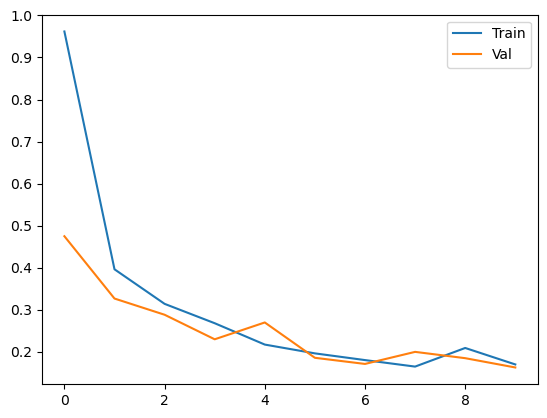

In [17]:
history_train, history_val = train_function(50)
history_train_list += history_train
history_val_list += history_val
plt.plot(history_train_list[1::5],label="Train")
plt.plot(history_val_list,label="Val")
plt.legend()

In [20]:
torch.save(model,f"TGAE2_GRUConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.model")

# Evaluation

In [21]:
snapshot_losses_list = []
for i_signal,(signal, y) in enumerate(zip(signals_val,y_val)):
    snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
    snapshot_losses_list.append(snapshot_losses)

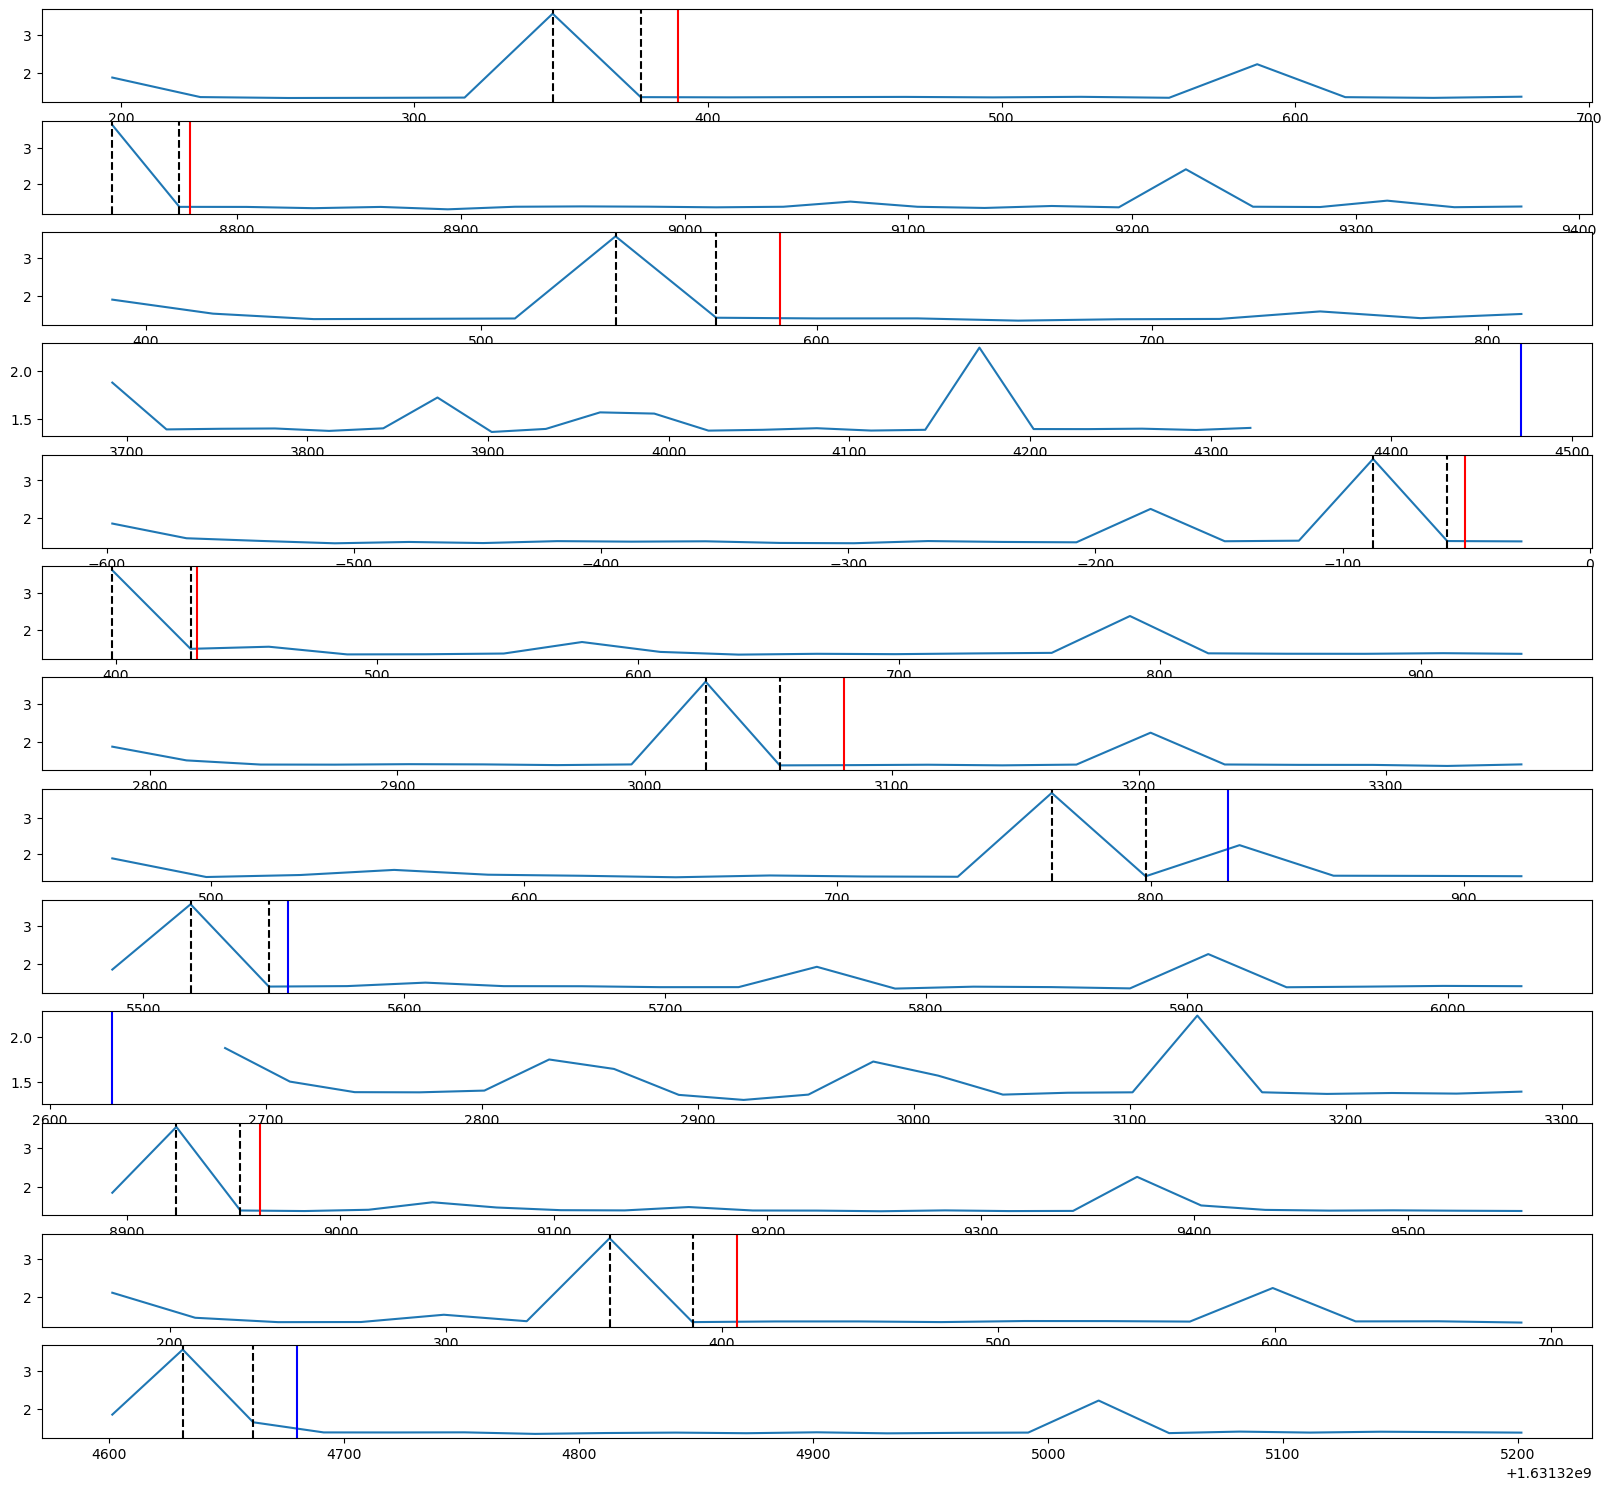

In [30]:
fig = plt.figure(figsize=(20,20))    
for i_signal,(signal, annotation, y) in enumerate(zip(signals_val, annotation_val, y_val)):
    snapshot_losses = snapshot_losses_list[i_signal]
    ts_list = signal.ts_list
    plt.subplot(len(signals_val)+1,1,i_signal+1)
#     print(len(snapshot_losses))
    plt.plot(ts_list,[np.max(loss) for loss in snapshot_losses])
    for ts, label in zip(ts_list, y):
        if label == 1:
            plt.axvline(x = ts, color = 'black', ls='--')
    if annotation[0] == 'dos':
        plt.axvline(x = float(annotation[1]), color = 'red', label = annotation[0])
    if annotation[0] == 'privesc':
        plt.axvline(x = float(annotation[1]), color = 'blue', label = annotation[0])
plt.savefig(f'val_res_TGAE2_GRUConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.png')

[(0, 87, 0), (1, 76, 0), (2, 69, 0), (3, 92, 0), (4, 80, 0), (5, 199, 1), (6, 71, 1), (7, 74, 0), (8, 73, 0), (9, 92, 0), (10, 67, 0), (11, 81, 0), (12, 75, 0), (13, 114, 0), (14, 69, 0), (15, 81, 0), (16, 73, 0)]


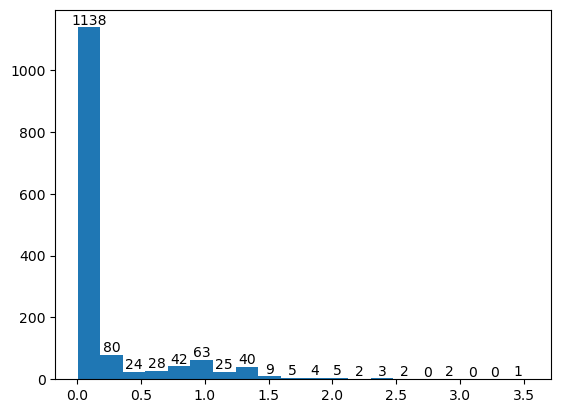

In [26]:
for signal, snapshot_losses, y in zip(signals_val, snapshot_losses_list,y_val):
#     print(snapshot_losses)
    print([(i_snapshot, len(loss),int(label)) for i_snapshot, (loss, label) in enumerate(zip(snapshot_losses, y))])
    loss_list = []
    for losses in snapshot_losses:
        loss_list += list(losses)
    counts, edges, bars = plt.hist(loss_list, bins=20)
    plt.bar_label(bars)
    plt.show()
    break
    

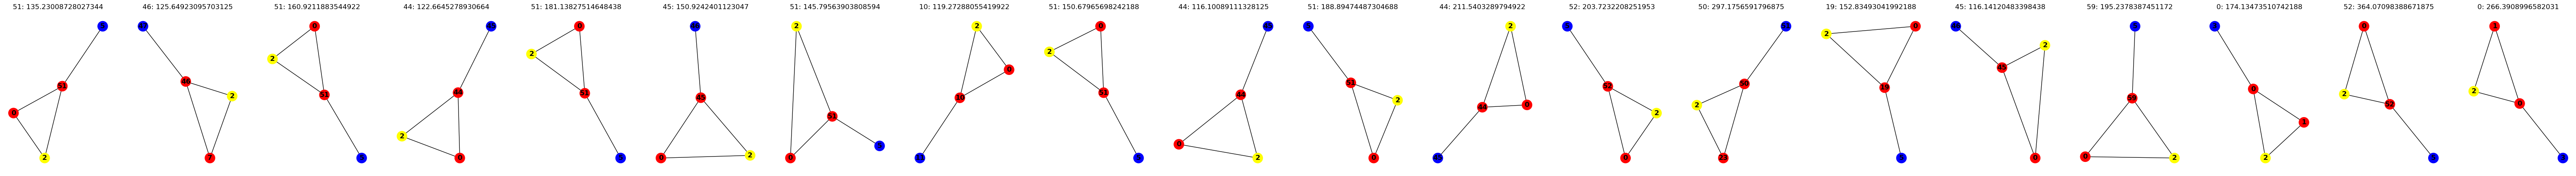

In [39]:
i_signal = 6
signal = signals_val[i_signal]
snapshot_losses = snapshot_losses_list[i_signal]

node_index = signal.node_index
node_attr = signal.node_attr
node_flag = signal.node_flag

edge_index = signal.edge_index
edge_flag = signal.edge_flag

raw_node_attr = signal.raw_node_attr
raw_edge_attr = signal.raw_edge_attr
raw_edge_index = signal.raw_edge_index
raw_edge_flag = signal.raw_edge_flag

node_index_split = torch.tensor_split(signal.node_index, signal.node_flag)
node_attr_split = torch.tensor_split(signal.node_attr, signal.node_flag)
edge_index_split = torch.tensor_split(signal.edge_index, signal.edge_flag, dim=1)

raw_edge_index_split = torch.tensor_split(signal.raw_edge_index, signal.raw_edge_flag, dim=1)
raw_edge_attr_split = np.split(signal.raw_edge_attr, signal.raw_edge_flag)
node_type_split = np.split(raw_node_attr[node_index],node_flag)

color_map = {
    'Process':'red',
    'User':'yellow',
    'Executable':'blue',
    'Socket':'green',
    'File':'orange',
}

snapshot_list = []
fig = plt.figure(figsize=(80,5))
for i_snapshot in range(signal.snapshot_count):
    
    i_node = np.argmax(snapshot_losses[i_snapshot])
    G = nx.Graph()
    _nodes = [(i_node, {'nodetype':nodetype[0]}) for i_node, nodetype in zip(list(range(node_index_split[i_snapshot].shape[0])), node_type_split[i_snapshot])]
    G.add_nodes_from(_nodes)
    G.add_edges_from(edge_index_split[i_snapshot].T.tolist())
    _subgraph_1 = G.subgraph([i_node]+list(G.neighbors(i_node)))
    ax = fig.add_subplot(1,signal.snapshot_count,i_snapshot+1)
    ax.set_title(f"{i_node}: {snapshot_losses[i_snapshot][i_node]}")
    nx.draw(_subgraph_1, with_labels=True, font_weight='bold',node_color=[color_map[node[1]['nodetype']] for node in _subgraph_1.nodes(data=True)])
    

(0, 50) {'162': 1, '240': 1}
(2, 50) {'162': 1, '240': 1}
(5, 50) {'162': 1, '240': 1}
Loss of 50: 1.8917551040649414


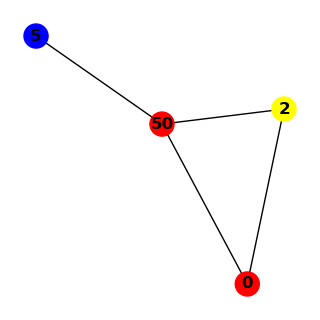

In [58]:
i_node = 50

edge_dict = {}

for i_edge in range(raw_edge_index_split[i_snapshot].shape[1]):
    _edge_index = raw_edge_index_split[i_snapshot][:,i_edge].tolist()
    if i_node in _edge_index:
        if tuple(_edge_index) not in edge_dict:
            edge_dict[tuple(_edge_index)] = {}
        if raw_edge_attr_split[i_snapshot][i_edge][0] not in edge_dict[tuple(_edge_index)]:
            edge_dict[tuple(_edge_index)][raw_edge_attr_split[i_snapshot][i_edge][0]] = 0
        edge_dict[tuple(_edge_index)][raw_edge_attr_split[i_snapshot][i_edge][0]] += 1

for _edge_index in edge_dict.keys():
    print(f"{_edge_index} {edge_dict[_edge_index]}")
    
print(f"Loss of {i_node}: {snapshot_losses[i_snapshot][i_node]}")
plt.figure(figsize=(3,3))
_subgraph_1 = G.subgraph([i_node]+list(G.neighbors(i_node)))
nx.draw(_subgraph_1, with_labels=True, font_weight='bold',node_color=[color_map[node[1]['nodetype']] for node in _subgraph_1.nodes(data=True)])

(0, 51) {'240': 20, '340': 33, '252': 21, '162': 12}
(2, 51) {'240': 20, '340': 33, '252': 21, '162': 12}
(5, 51) {'240': 20, '340': 33, '252': 21, '162': 12}
Loss of 51: 135.23008728027344


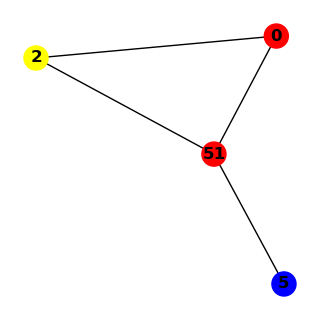

In [59]:
i_node = 51

edge_dict = {}

for i_edge in range(raw_edge_index_split[i_snapshot].shape[1]):
    _edge_index = raw_edge_index_split[i_snapshot][:,i_edge].tolist()
    if i_node in _edge_index:
        if tuple(_edge_index) not in edge_dict:
            edge_dict[tuple(_edge_index)] = {}
        if raw_edge_attr_split[i_snapshot][i_edge][0] not in edge_dict[tuple(_edge_index)]:
            edge_dict[tuple(_edge_index)][raw_edge_attr_split[i_snapshot][i_edge][0]] = 0
        edge_dict[tuple(_edge_index)][raw_edge_attr_split[i_snapshot][i_edge][0]] += 1

for _edge_index in edge_dict.keys():
    print(f"{_edge_index} {edge_dict[_edge_index]}")
    
print(f"Loss of {i_node}: {snapshot_losses[i_snapshot][i_node]}")
plt.figure(figsize=(3,3))
_subgraph_1 = G.subgraph([i_node]+list(G.neighbors(i_node)))
nx.draw(_subgraph_1, with_labels=True, font_weight='bold',node_color=[color_map[node[1]['nodetype']] for node in _subgraph_1.nodes(data=True)])

51: 135.23008728027344


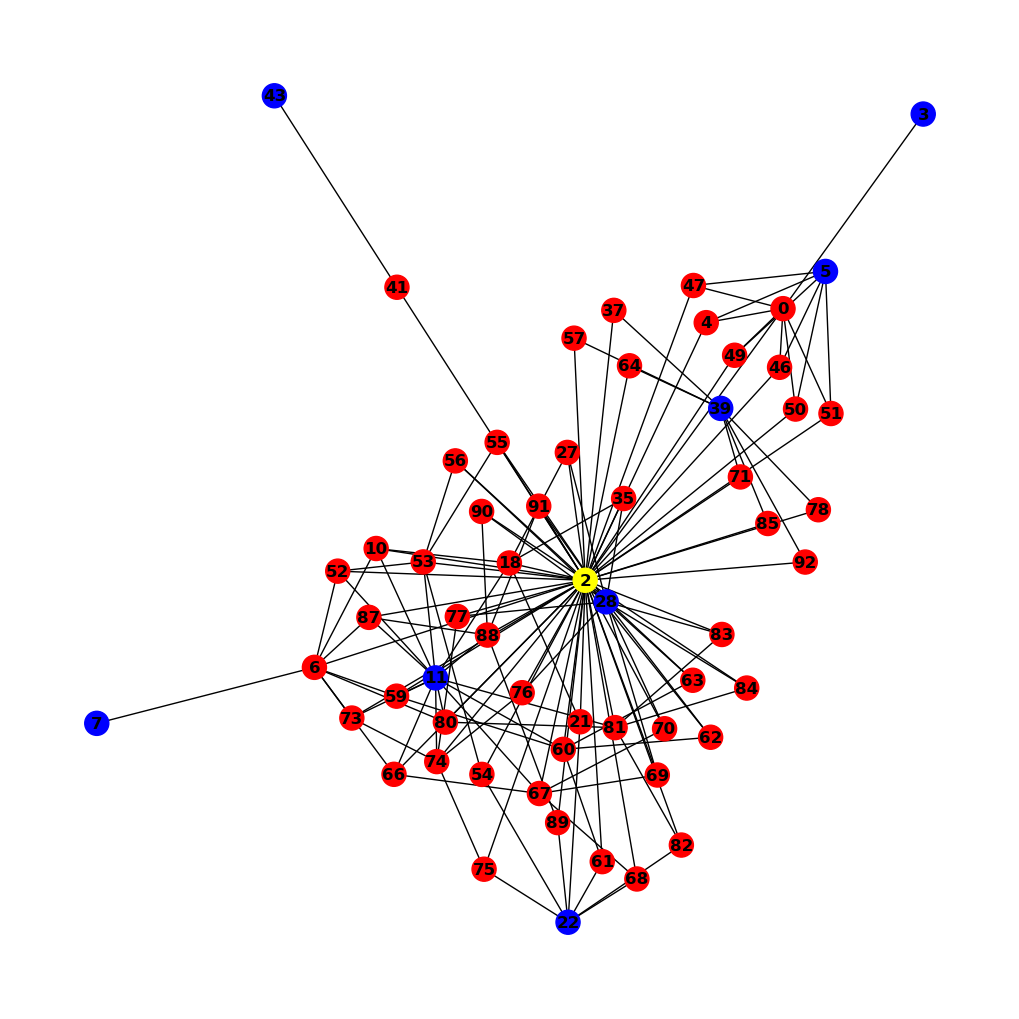

In [52]:
i_snapshot = 0

i_node = np.argmax(snapshot_losses[i_snapshot])
print(f"{i_node}: {snapshot_losses[i_snapshot][i_node]}")
G = nx.MultiGraph()
_nodes = [(i_node, {'nodetype':nodetype[0]}) for i_node, nodetype in zip(list(range(node_index_split[i_snapshot].shape[0])), node_type_split[i_snapshot])]
G.add_nodes_from(_nodes)
G.add_edges_from(edge_index_split[i_snapshot].T.tolist())
user_nodes = [node[0] for node in G.nodes(data=True) if node[1]['nodetype']=='User']
exe_nodes = [node[0] for node in G.nodes(data=True) if node[1]['nodetype']=='Executable']

_subgraph_nodes = []
for a in user_nodes:
    for b in exe_nodes:
        for path in nx.all_simple_paths(G,a,b,cutoff=2):
            _subgraph_nodes += list(path)
# print(_subgraph_nodes)
plt.figure(figsize=(10,10))
_subgraph_2 = G.subgraph(_subgraph_nodes)
nx.draw(_subgraph_2, with_labels=True, font_weight='bold',node_color=[color_map[node[1]['nodetype']] for node in _subgraph_2.nodes(data=True)])

# Edge Analysis

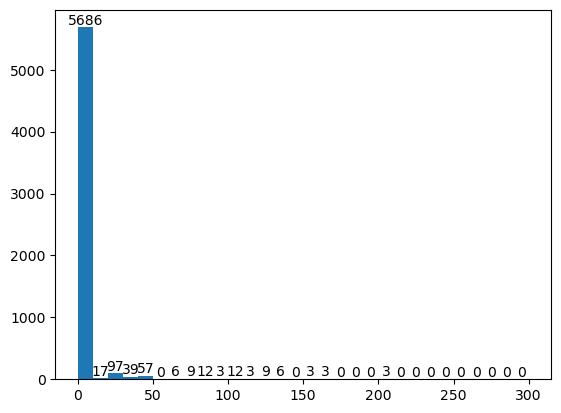

In [66]:
edge_dict = {}
for i_snapshot in range(signal.snapshot_count):
    for i_edge in range(raw_edge_index_split[i_snapshot].shape[1]):
        _edge_index = [i_snapshot] + raw_edge_index_split[i_snapshot][:,i_edge].tolist()
        if tuple(_edge_index) not in edge_dict:
            edge_dict[tuple(_edge_index)] = 0
        edge_dict[tuple(_edge_index)] += 1

counts, edges, bars = plt.hist(edge_dict.values(),range=(0, 300), bins=30)
plt.bar_label(bars)
plt.show()

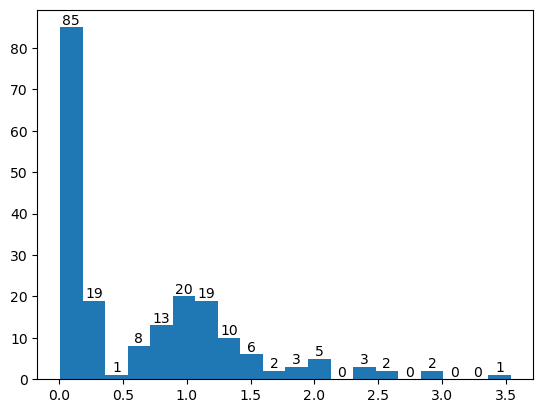

In [28]:
counts, edges, bars = plt.hist(snapshot_losses_list[0][5],bins=20)
plt.bar_label(bars)
plt.show()

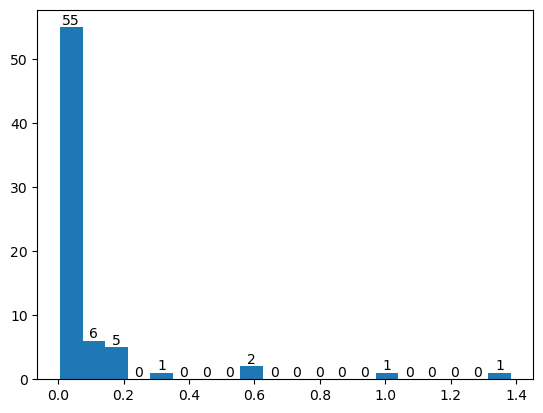

In [27]:
counts, edges, bars = plt.hist(snapshot_losses_list[0][6],bins=20)
plt.bar_label(bars)
plt.show()

In [ ]:
# history_train, history_val = train_function(50)
# history_train_list += history_train
# history_val_list += history_val
# plt.plot(history_train_list[1::5],label="Train")
# plt.plot(history_val_list,label="Val")
# plt.legend()

In [ ]:
# fig = plt.figure(figsize=(20,20))    
# for i_signal,(signal,y) in enumerate(zip(signals_val,y_val)):
#     snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
# #                 print(np.mean(val_loss))
# #     val_losses.append(np.mean(snapshot_losses))
#     ts_list = signal.ts_list
#     plt.subplot(len(signals_val)+1,1,i_signal+1)
# #     print(len(snapshot_losses))
#     plt.plot(ts_list,[np.max(loss) for loss in snapshot_losses])
#     if y[0] == 'dos':
#         plt.axvline(x = float(y[1]), color = 'red', label = y[0])
#     if y[0] == 'privesc':
#         plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# # plt.show()
# plt.savefig(f'val_res_TGAE_NNConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.png')

In [ ]:
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], use_cuda=True, record_shapes=True) as prof:
#         history_train, history_val = train_function(1)
#         history_train_list += history_train
#         history_val_list += history_val
#         plt.plot(history_train_list[1::5],label="Train")
#         plt.plot(history_val_list,label="Val")
#         plt.legend()
# print(prof.key_averages().table(sort_by="cuda_time_total"))

In [ ]:
# print(prof.key_averages().table(sort_by="cpu_time_total"))

In [ ]:
# fig = plt.figure(figsize=(20,20))    
# for i_signal,(signal,y) in enumerate(zip(signals_val,y_val)):
#     snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
# #                 print(np.mean(val_loss))
# #     val_losses.append(np.mean(snapshot_losses))
#     ts_list = signal.ts_list
#     plt.subplot(len(signals_val)+1,1,i_signal+1)
# #     print(len(snapshot_losses))
#     plt.plot(ts_list,snapshot_losses[:-1])
#     if y[0] == 'dos':
#         plt.axvline(x = float(y[1]), color = 'red', label = y[0])
#     if y[0] == 'privesc':
#         plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# # plt.show()
# plt.savefig('val_res.png')

In [ ]:
# torch.save(model,f"{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.model")

In [ ]:
# history_train, history_val = train_function(100)
# history_train_list += history_train
# history_val_list += history_val
# plt.plot(history_train_list[1::5],label="Train")
# plt.plot(history_val_list,label="Val")
# plt.legend()

In [ ]:
# states_encoder_val = []
# states_decoder_val = []
# for num_node in nums_node_val:
#     states_encoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.gnn_out_channels))
#     states_decoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.embedding_hidden_nums[-1]))    

# fig = plt.figure(figsize=(20,20))    
# for i_sample, (sample, y, hidden_encoder_global, hidden_decoder_global) in enumerate(zip(X_val, y_val, states_encoder_val, states_decoder_val)):
#     val_loss = test_loop(sample, hidden_encoder_global, hidden_decoder_global, model, loss_f, optimizer, device)
#     # print(np.mean(val_loss))
#     ts_list = [snapshot.timestamp for snapshot in sample]
#     plt.subplot(len(X_val)+1,1,i_sample+1)
#     plt.plot(ts_list,val_loss)
#     if y[0] == 'dos':
#         plt.axvline(x = float(y[1]), color = 'red', label = y[0])
#     if y[0] == 'privesc':
#         plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# plt.show()